# Planejamento da solução

-- Objetivo do problema: Previsão do primeiro destino que um novo usuário irá escolher

- Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )
            
           Gross Revenue = ( Fee*Numero cliente ) - CAC 

#
-- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**
        
--- Esperado 16 ciclos

# 0.0 Imports

In [37]:
import random
import pickle
import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt
from pycorrcat  import pycorrcat

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as me
from scikitplot import metrics         as mt
from imblearn   import combine

from keras      import models as ml
from keras      import layers as la

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()
    

## 0.2 Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv', low_memory=False)
df_sessions = pd.read_csv('../data/raw/sessions.csv', low_memory=False)

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1 Data Dimension

In [5]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 213451
number of cols: 16


In [6]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of cols: {df_sessions.shape[1]}')

number of rows: 10567737
number of cols: 6


## 1.2 Data Types

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [8]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [10]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4 Replace NA

In [11]:
# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].astype('int64').mean()
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3% 
# # action - 0.7% 
# # action_type - 11% 
# # action_detail - 11% 
# # secs_elapsed - 1.2%
df_sessions = df_sessions.dropna()

In [12]:
df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [13]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5 Change Types

In [14]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

In [15]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6 Check Balanced Data

In [16]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.7 Descriptive Statistical

In [17]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop('user_id', axis=1)
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1 Numerical Attributes - Users

In [18]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
age,16.0,115.0,99.0,37.405591,34.0,13.939900,2.089718,6.516468
signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604723,2.705871,5.928298


### 1.7.2 Numerical Attributes - Sessions

In [19]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes_sessions.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.39327,11.137761,154.84312


### 1.7.3 Categorical Attributes - Users

In [20]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.7.4 Categorical Attributes - Sessions

In [21]:
cat_attributes_sessions.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


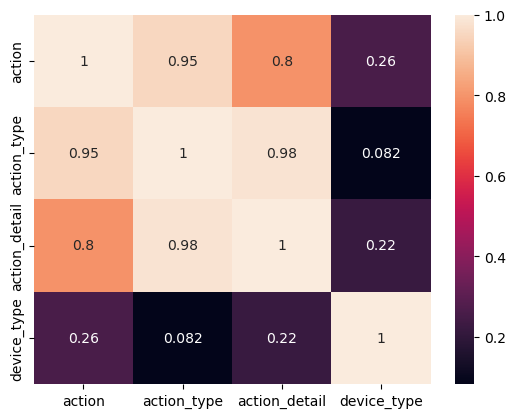

In [22]:
# Cramer V correlation
d = pycorrcat.corr_matrix(cat_attributes_sessions, ['action', 'action_type', 'action_detail', 'device_type'])
sns.heatmap(d, annot=True);

# 2.0 Data Filtering

In [23]:
df2 = df1.copy()

## 2.1. Filtering Rows

In [24]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df2 = df2[( df2['age'] > 15 ) & ( df2['age'] < 120 )]

## 2.2. Columns Selection

# 3.0 Feature Engineering

In [25]:
df3 = df2.copy()

In [26]:
 # days from first active up to first booking
df3['first_active'] = pd.to_datetime(df3['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df3['days_from_frist_active_until_booking'] = (df3['date_first_booking'] - df3['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df3['days_from_first_active_until_account_created'] = (df3['date_account_created'] - df3['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df3['days_from_account_created_until_first_booking'] = (df3['date_first_booking'] - df3['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df3['year_first_active'] = df3['first_active'].dt.year

# month first active
df3['month_fist_active'] = df3['first_active'].dt.month

# day first active
df3['day_first_active'] = df3['first_active'].dt.day

# day of week first active
df3['day_of_week_first_active'] = df3['first_active'].dt.dayofweek

# week of year first active
df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df3['year_first_booking'] = df3['date_first_booking'].dt.year

# month first booking
df3['month_first_booking'] = df3['date_first_booking'].dt.month

# day first booking
df3['day_first_booking'] = df3['date_first_booking'].dt.day

# day of week first booking
df3['day_of_week_first_booking'] = df3['date_first_booking'].dt.dayofweek

# week of year first booking
df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df3['year_account_created'] = df3['date_account_created'].dt.year

# month  account_created
df3['month_account_created'] = df3['date_account_created'].dt.month

# day  account_created
df3['day_account_created'] = df3['date_account_created'].dt.day

# day of week  account_created
df3['day_of_week_account_created'] = df3['date_account_created'].dt.dayofweek

# week of year  account_created
df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear

C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_12300\466401703.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_12300\466401703.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_12300\466401703.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear


In [27]:
df3.isna().sum()

id                                               0
date_account_created                             0
timestamp_first_active                           0
date_first_booking                               0
gender                                           0
age                                              0
signup_method                                    0
signup_flow                                      0
language                                         0
affiliate_channel                                0
affiliate_provider                               0
first_affiliate_tracked                          0
signup_app                                       0
first_device_type                                0
first_browser                                    0
country_destination                              0
first_active                                     0
days_from_frist_active_until_booking             0
days_from_first_active_until_account_created     0
days_from_account_created_until

In [28]:
df3.shape

(122636, 35)

In [30]:
# Drop original datetime
cols = ['date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active']
df3 = df3.drop( cols, axis=1 )

# 4.0 Exploratory Data Analysis

# 5.0 Data Preparation

In [45]:
df5 = df3.copy()

## 5.1 Balanced Dataset

In [46]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df5.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df5_dummy = pd.DataFrame(ohe.fit_transform(df5[ col_cat] ).toarray(), index=df5.index)

# join numerical and categorical
df51 = pd.concat([df5[col_num], df5_dummy], axis=1)


df5['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [47]:
# # create ratio of balanced variable
# ratio_balanced =  {'NDF': 54852,
#                    'US':  48057,
#                    'other': 6*7511,
#                    'FR': 12*3669,
#                    'IT': 20*2014,
#                    'GB': 26*1758,
#                    'ES': 26*1685,
#                    'CA': 40*1064,
#                    'DE': 48*841,
#                    'NL': 75*595,
#                    'AU': 95*433,
#                    'PT': 280*157}

# # define sampler
# smt = combine.SMOTETomek(sampling_strategy=ratio_balanced, random_state=42, n_jobs=-1)

# # apply sampler
# X_smt, y_smt = smt.fit_resample(df51, df5['country_destination'])

# y_smt.value_counts()

f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


NDF      54850
US       47533
GB       45651
other    44753
NL       44620
PT       43960
FR       43865
ES       43754
CA       42541
AU       41133
DE       40357
IT       40202
Name: country_destination, dtype: int64

In [48]:
# # numerical data
# df52 = X_smt[col_num]

# # categorical data
# df53 = X_smt.drop(col_num, axis=1)
# df54 = pd.DataFrame(ohe.inverse_transform(df53), columns=col_cat, index=df53.index)

# # join numerical categorical
# df55 = pd.concat([df52, df54], axis=1)
# df55['country_destination'] = y_smt

In [49]:
# # Saving Interim Data
# df55.to_parquet('../data/interim/df55.parquet')

df55 = pd.read_parquet('../data/interim/df55.parquet')

In [55]:
df5.dtypes

id                                               object
gender                                           object
age                                               int64
signup_method                                    object
signup_flow                                       int64
language                                         object
affiliate_channel                                object
affiliate_provider                               object
first_affiliate_tracked                          object
signup_app                                       object
first_device_type                                object
first_browser                                    object
country_destination                              object
days_from_frist_active_until_booking              int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
year_first_active                                 int64
month_fist_active                               

## 5.2 Encoding

In [56]:
# dummy variable
df51_dummy = pd.get_dummies(df55.drop(['country_destination'], axis=1))

# join id
df5 = pd.concat([df55[['country_destination']], df51_dummy], axis=1)

In [57]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

In [58]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6.0 Feature Selection

In [59]:
# cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates

df6_train = X_train.copy()


df6_test = X_test.copy()

In [ ]:
# # Saving Interim Data
# df6_train.to_parquet('../data/interim/df6_train.parquet')
# df6_test.to_parquet('../data/interim/df6_test.parquet')

# pickle.dump(y_train, open('../data/interim/y_train.pkl', 'wb'))
# pickle.dump(y_test, open('../data/interim/y_test.pkl', 'wb'))

# 7.0 Machine Learning Modelling

In [61]:
x_train = df6_train.copy()
x_test = df6_test.copy()

## 7.1 Baseline Model

In [62]:
cd_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
cd_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=cd_list, weights=cd_weights, k=k_num)

### 7.1.1 Baseline Model Performance

Accuracy: 0.09384494205018566
Accuracy: 0.08311501162516119
Accuracy: -0.00031751677827096536
              precision    recall  f1-score   support

          AU       0.11      0.00      0.01      8227
          CA       0.09      0.01      0.02      8508
          DE       0.06      0.01      0.01      8071
          ES       0.08      0.01      0.02      8751
          FR       0.08      0.03      0.04      8773
          GB       0.08      0.01      0.02      9130
          IT       0.07      0.02      0.03      8040
         NDF       0.10      0.44      0.17     10970
          NL       0.06      0.00      0.01      8924
          PT       0.13      0.00      0.00      8792
          US       0.09      0.39      0.14      9507
       other       0.09      0.07      0.08      8951

    accuracy                           0.09    106644
   macro avg       0.09      0.08      0.05    106644
weighted avg       0.09      0.09      0.05    106644



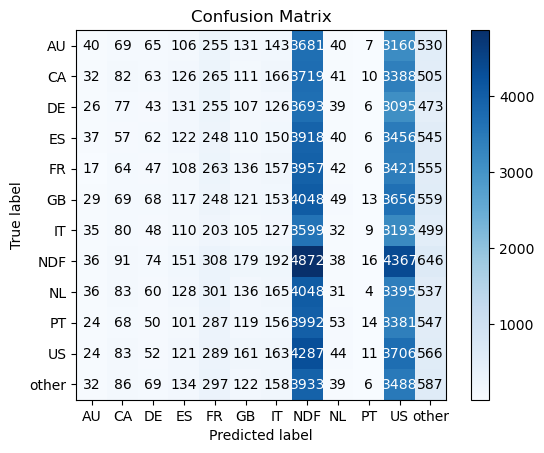

In [63]:
# Accuracy
acc_random = me.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = me.balanced_accuracy_score(y_test, yhat_random)
print(f'Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = me.cohen_kappa_score(y_test, yhat_random)
print(f'Accuracy: {kappa_random}')

# Classification report
print(me.classification_report( y_test, yhat_random ))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False);

## 7.1 Neural Network MLP

In [64]:
# Encoding variable response
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()


# model definition
model = ml.Sequential()
model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(la.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=50, verbose=False)

### 7.1.1 NN Performance

3333/3333 [==============================] - 3s 757us/step
Accuracy: 0.19204080867184276
Balanced Accuracy: 0.16670386812727114
Kappa Score: 0.11158744197676174


f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

          AU       0.55      0.00      0.00      8227
          CA       0.00      0.00      0.00      8508
          DE       0.00      0.00      0.00      8071
          ES       0.00      0.00      0.00      8751
          FR       0.00      0.00      0.00      8773
          GB       0.00      0.00      0.00      9130
          IT       0.00      0.00      0.00      8040
         NDF       1.00      1.00      1.00     10970
          NL       0.00      0.00      0.00      8924
          PT       0.00      0.00      0.00      8792
          US       0.10      1.00      0.18      9507
       other       0.50      0.00      0.00      8951

    accuracy                           0.19    106644
   macro avg       0.18      0.17      0.10    106644
weighted avg       0.20      0.19      0.12    106644



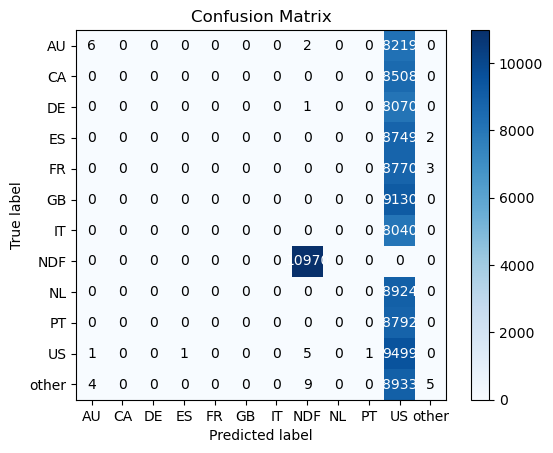

In [65]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]


# -------------------------- Metrics --------------------------
# Accuracy
acc_nn = me.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = me.balanced_accuracy_score(y_test, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = me.cohen_kappa_score(y_test, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(me.classification_report(y_test, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False);

### 7.1.2 NN Performance - Cross-Validation

In [ ]:
# # generate k-fold
# num_folds = 5
# kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# balanced_acc_list = []
# kappa_acc_list = []

# i = 1
# for train_ix, val_ix in kfold.split(x_train, y_train):
#     print(f'Fold Number: {i}/{num_folds}')
    
#     # get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]
    
#     # target hot-encoding
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
#     model.add(la.Dense(12, activation='softmax'))

#     # compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # training model
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

#     # prediction
#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
    
#     # prepare data
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1, -1)[0]

#     # metrics
#     ## Balanced Accuracy 
#     balanced_acc_nn = me.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
    
#     ## Kappa Metrics
#     kappa_acc_nn = me.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_acc_list.append(kappa_acc_nn)
    
#     i += 1

In [ ]:
# print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}')
# print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')